In [ ]:
import sys, os
from matplotlib import pyplot as plt

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')

# %cd /content/gdrive/MyDrive/mat099

# from classes import StyleTransferProcessor

Mounted at /content/gdrive


In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
#import PIL.Image
from PIL import Image
import time
import functools
import sys
import datetime

class StyleTransferProcessor:

    def __init__(self
                 ,contentPath =      None
                 ,stylePath =        None
                 ,saveDir =          None
                 ,max_dim =          512
                 ,resizeContentImg = False
                 ,cropContentImg =   True
                 ,resizeStyleImg =   False
                 ,cropStyleImg =     False
                 ):

        self.max_dim =          max_dim
        self.resizeContentImg = resizeContentImg
        self.cropContentImg =   cropContentImg
        self.resizeStyleImg =   resizeStyleImg
        self.cropStyleImg =     cropStyleImg

        if contentPath is None:
            self.content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
        else:
            self.content_path = contentPath

        if stylePath is None:
            self.style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
        else:
            self.style_path = stylePath

        self.setSaveDir(saveDir)

        self.content_image = StyleTransferProcessor.load_img(self.content_path, max_dim, resizeContentImg, cropContentImg)
        self.style_image = StyleTransferProcessor.load_img(self.style_path, max_dim, resizeStyleImg, cropStyleImg)

        # Download vgg:
        self.vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    def setSaveDir(self, saveDir):
        if saveDir is None:
            self.saveDir = 'style_transfer_generated_pictures/'
        else:
            if (saveDir[-1] == '/'):
                saveDir = saveDir[:-1]
            self.saveDir = 'style_transfer_generated_pictures/' + saveDir + '/'

        if 'google.colab' in sys.modules:
            self.saveDir = '/content/gdrive/MyDrive/mat099/output/' + self.saveDir

        os.makedirs(self.saveDir, exist_ok=True)
        return None

    def sequence(self
                ,content_path =   None
                ,style_image =    None
                ,content_layers = ['block5_conv2']
                ,style_layers =   ['block1_conv1',
                                   'block2_conv1',
                                   'block3_conv1',
                                   'block4_conv1',
                                   'block5_conv1']
                ,style_weight =   1e-2
                ,content_weight = 1e4
                ,train_steps =    3
                ,opt =            tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
                ,longer_opt =     True
                ,display_train =  False
                ,save_image =     False
                ,use_timestamp =  False
                ):
        print('save_image: ')
        print(save_image)
        if content_path is not None:
            self.content_path = content_path
            print('content path provided: ')
            print(self.content_path)
            self.content_image = StyleTransferProcessor.load_img(self.content_path, self.max_dim, self.resizeContentImg, self.cropContentImg)

        if style_image is not None:
            print('using style path: ')
            print(self.style_path)
            self.style_image = StyleTransferProcessor.load_img(self.style_path, self.max_dim, self.resizeStyleImg, self.cropStyleImg)

        @tf.function()
        def train_step(image):
            with tf.GradientTape() as tape:
                outputs = extractor(image)
                loss = StyleTransferProcessor.style_content_loss(outputs, style_targets, style_weight, num_style_layers, content_targets, content_weight, num_content_layers)

            grad = tape.gradient(loss, image)
            opt.apply_gradients([(grad, image)])
            image.assign(StyleTransferProcessor.clip_0_1(image))

        num_content_layers = len(content_layers)
        num_style_layers = len(style_layers)

        # Create the model
        style_extractor = StyleTransferProcessor.vgg_layers(style_layers)
        style_outputs = style_extractor(self.style_image*255)

        extractor = StyleContentModel(style_layers, content_layers)
        results = extractor(tf.constant(self.content_image))

        style_targets = extractor(self.style_image)['style']
        content_targets = extractor(self.content_image)['content']

        image = tf.Variable(self.content_image)

        # Generate image
        for i in range(train_steps):
            train_step(image)

        if longer_opt:
            epochs = 10
            steps_per_epoch = 100
            step = 0
            for n in range(epochs):
                for m in range(steps_per_epoch):
                    step += 1
                    train_step(image)
                    print(".", end='', flush=True)
                if display_train:
                    display.clear_output(wait=True)
                    display.display(StyleTransferProcessor.tensor_to_image(image))
                    print("Train step: {}".format(step))
        print('before enter if save_image: ')
        if save_image:
            print('ENTERED save_image')
            picName = self.content_path.split('/')[-1].split('.')[0]
            print(f'picName: {picName}')
            picName = self.saveDir + picName
            self.save_generated_image(image = image, filename = picName, use_timestamp = use_timestamp)

        return self.tensor_to_image(image)

    @staticmethod
    def total_variation_loss(image):
        x_deltas, y_deltas = StyleTransferProcessor.high_pass_x_y(image)
        return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))
    @staticmethod
    def high_pass_x_y(image):
        x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
        y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
        return x_var, y_var
    @staticmethod
    def tensor_to_image(tensor):
        tensor = tensor*255
        tensor = np.array(tensor, dtype=np.uint8)
        if np.ndim(tensor)>3:
            assert tensor.shape[0] == 1
            tensor = tensor[0]
        return Image.fromarray(tensor)
    @staticmethod
    def cut_ctr(array: np.ndarray, sizes: tuple) -> np.ndarray:
        """
        Cut a multi-dimensional array at its center, according to sizes
        :param array: multidimensional array
        :param sizes: tuple of the same length as array.ndim
        :return: multidimensional array, center cut
        """
        array = array.copy()
        if not (array.ndim == len(sizes)):
            raise ArgumentError('array.ndim must be equal to len(sizes)')
        for axis in range(array.ndim):
            axis_target_size = sizes[axis]
            axis_original_size = array.shape[axis]
            if axis_target_size > axis_original_size:
                raise ValueError(
                    'Can\'t have target size {} for axis {} with original size {}'.format(axis_target_size, axis,
                                                                                            axis_original_size))
            elif axis_target_size < axis_original_size:
                axis_start_idx = (axis_original_size - axis_target_size) // 2
                axis_end_idx = axis_start_idx + axis_target_size
                array = np.take(array, np.arange(axis_start_idx, axis_end_idx), axis)
        return array
    @staticmethod
    def load_img(img, max_dim = 512, resize = False, crop = True):
        # img = tf.io.read_file(path_to_img)
        # img = tf.image.decode_image(img, channels=3)
        # img = tf.image.convert_image_dtype(img, tf.float32)
        if isinstance(img, str):
            img_pil = Image.open(img).convert('RGB')
        elif isinstance(img, Image.Image):
            img_pil = img
        else:
            raise ValueError("Unsupported input type. Provide either a file path or a Pillow Image.")

        img = tf.image.convert_image_dtype(np.array(img_pil), tf.float32)

        if resize:
            largest_dim = tf.dtypes.cast(tf.reduce_max(tf.shape(img)[:-1]), tf.float32)
            max_dim = largest_dim if largest_dim < max_dim else max_dim

            shape = tf.cast(tf.shape(img)[:-1], tf.float32)
            long_dim = max(shape)
            scale = max_dim / long_dim
            new_shape = tf.cast(shape * scale, tf.int32)
            img = tf.image.resize(img, new_shape)

        if crop:
            target_size = (max_dim, max_dim, 3)
            img = StyleTransferProcessor.cut_ctr(img.numpy(), target_size)

        img = img[tf.newaxis, :]
        return img
    @staticmethod
    def imshow(image, title=None):
        if len(image.shape) > 3:
            image = tf.squeeze(image, axis=0)
        plt.imshow(image)
        if title:
            plt.title(title)
    @staticmethod
    def vgg_layers(layer_names):
        """ Creates a VGG model that returns a list of intermediate output values."""
        # Load our model. Load pretrained VGG, trained on ImageNet data
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False

        outputs = [vgg.get_layer(name).output for name in layer_names]

        model = tf.keras.Model([vgg.input], outputs)
        return model
    @staticmethod
    def gram_matrix(input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
        return result/(num_locations)
    @staticmethod
    def clip_0_1(image):
        return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    def style_content_loss(outputs, style_targets, style_weight, num_style_layers, content_targets, content_weight, num_content_layers):
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                            for name in style_outputs.keys()])
        style_loss *= style_weight / num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                                for name in content_outputs.keys()])
        content_loss *= content_weight / num_content_layers
        loss = style_loss + content_loss
        return loss

    def save_generated_image(self, image, filename, use_timestamp = False):
        if use_timestamp:
            current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            filename = filename + '-' + current_time
        filename += '.png'
        generated_image = self.tensor_to_image(image)
        generated_image.save(filename)
        print(f"Generated image saved as {filename}")
        return None

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = StyleTransferProcessor.vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [StyleTransferProcessor.gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}


In [ ]:
# Providing image paths and saving the pictures

myStylePath = "/content/gdrive/MyDrive/mat099/style_transfer_sources/styles/Pierre-Auguste_Renoir_42.jpg"
myContentPath = "/content/gdrive/MyDrive/mat099/datasets/data/nat/D08_I_t_0066.jpg"
myContentPath2 = "/content/gdrive/MyDrive/mat099/datasets/data/nat/D09_I_t_0017.jpg"

mySaveDir = 'generatedSet08'

myProcessor = StyleTransferProcessor(#myContentPath
                                     #,myStylePath
                                     saveDir =           mySaveDir
                                     ,max_dim =          500
                                     ,resizeContentImg = False
                                     ,cropContentImg =   True)
myImage = myProcessor.sequence(
                    #  content_path = None
                    # ,style_image =  None
                     content_path =   myContentPath
                    ,style_image =    myStylePath
                    ,content_layers = ['block5_conv2']
                    ,style_layers =   ['block1_conv1',
                                      'block2_conv1',
                                      'block3_conv1',
                                      'block4_conv1',
                                      'block5_conv1']
                    ,style_weight =   1e-2
                    ,content_weight = 1e4
                    ,train_steps =    1
                    ,opt =            tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
                    ,longer_opt =     True
                    )

myImage2 = myProcessor.sequence(
                    #  content_path = None
                    # ,style_image =  None
                     content_path =   myContentPath2
                    ,style_image =    myStylePath
                    ,content_layers = ['block5_conv2']
                    ,style_layers =   ['block1_conv1',
                                      'block2_conv1',
                                      'block3_conv1',
                                      'block4_conv1',
                                      'block5_conv1']
                    ,style_weight =   1e-2
                    ,content_weight = 1e4
                    ,train_steps =    1
                    ,opt =            tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
                    ,longer_opt =     True
                    )


save_image: 
False
content path provided: 
<PIL.Image.Image image mode=RGB size=2592x1936 at 0x7F99320497E0>
using style path: 
/root/.keras/datasets/kandinsky5.jpg
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

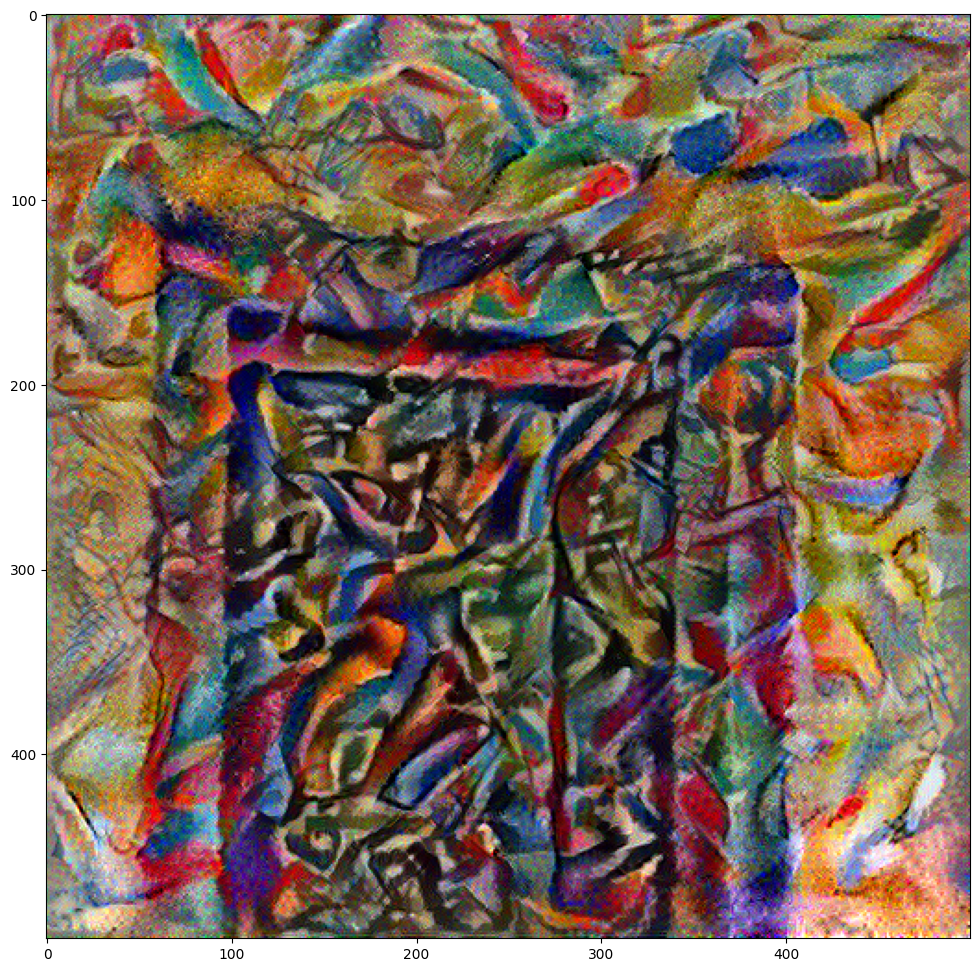

In [ ]:
# Test to see if it can handle PIL image objects instead of paths

myStylePath = "/content/gdrive/MyDrive/mat099/style_transfer_sources/styles/Pierre-Auguste_Renoir_42.jpg"
myContentPath = "/content/gdrive/MyDrive/mat099/datasets/data/nat/D08_I_t_0066.jpg"
myContentPath2 = "/content/gdrive/MyDrive/mat099/datasets/data/nat/D09_I_t_0017.jpg"

mySaveDir = 'generatedSet08'

intensities = {
    'low':      {'style': 1e-9, 'content': 1e11, 'saveDir': 'devices_123_style_transfer_low'}
    ,'medium' : {'style': 1e-3, 'content': 1e3, 'saveDir': 'devices_123_style_transfer_med'}
    ,'high' :   {'style': 0.9, 'content': 1e4, 'saveDir': 'devices_123_style_transfer_high'}
}
testIntensity = 'high'

pilContentImg = Image.open(myContentPath2).convert('RGB')

myProcessor = StyleTransferProcessor(#myContentPath
                                     #,myStylePath
                                     saveDir =           mySaveDir
                                     ,max_dim =          500
                                     ,resizeContentImg = False
                                     ,cropContentImg =   True)
myImage = myProcessor.sequence(
                    #  content_path = None
                    # ,style_image =  None
                     content_path =   pilContentImg
                    ,style_image =    myStylePath
                    ,content_layers = ['block5_conv2']
                    ,style_layers =   ['block1_conv1',
                                      'block2_conv1',
                                      'block3_conv1',
                                      'block4_conv1',
                                      'block5_conv1']
                    ,style_weight =   intensities[testIntensity]['style']
                    ,content_weight = intensities[testIntensity]['content']
                    ,train_steps =    1
                    ,opt =            tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
                    ,longer_opt =     True
                    )

plt.imshow(myImage)


In [ ]:
# Devices 1, 2, 3 on three levels of intensity

pictureFolder = "/content/gdrive/MyDrive/mat099/devices_123/"
myStylePath = "/content/gdrive/MyDrive/mat099/style_transfer_sources/styles/Pierre-Auguste_Renoir_42.jpg"

myProcessor = StyleTransferProcessor(#myContentPath
                                     #,myStylePath
                                     saveDir =           'test05'
                                     ,max_dim =          540
                                     ,resizeContentImg = False
                                     ,cropContentImg =   True
                                     )
intensities = {
    'low':      {'style': 1e-9, 'content': 1e11, 'saveDir': 'devices_123_style_transfer_low2'}
    ,'medium' : {'style': 1e-3, 'content': 1e3, 'saveDir': 'devices_123_style_transfer_med2'}
    ,'high' :   {'style': 0.9, 'content': 1e4, 'saveDir': 'devices_123_style_transfer_high2'}
}

for intensity in ['high', 'low']:
    style_weight =   intensities[intensity]['style']
    content_weight = intensities[intensity]['content']
    mySaveDir =      intensities[intensity]['saveDir']

    myProcessor.setSaveDir(mySaveDir)

    print(f'Style weight: {style_weight}')
    print(f'Content weight: {content_weight}')
    print(f'saveDir: {myProcessor.saveDir}')

    try:
        already_done = [i.split('-2023')[0] for i in os.listdir("/content/gdrive/MyDrive/mat099/output/style_transfer_generated_pictures/" + mySaveDir)]
    except:
        already_done = []
    #print(already_done)

    for i in sorted(os.listdir(pictureFolder))[:]:
            #print(i)
            if i.split('.')[0] not in already_done :
                current_content_path = pictureFolder + i
                #print(current_content_path)
                try:
                    myProcessor.sequence(
                                content_path =   current_content_path
                                ,style_image =    myStylePath
                                ,content_layers = ['block5_conv2']
                                ,style_layers =   ['block1_conv1',
                                                'block2_conv1',
                                                'block3_conv1',
                                                'block4_conv1',
                                                'block5_conv1']
                                ,style_weight =   style_weight
                                ,content_weight = style_weight
                                ,train_steps =    1
                                ,opt =            tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
                                ,longer_opt =     True

                                ,save_image = True
                                )
                except:
                    print(f'Failed to process image: {current_content_path}')



Style weight: 0.9
Content weight: 10000.0
saveDir: /content/gdrive/MyDrive/mat099/output/style_transfer_generated_pictures/devices_123_style_transfer_high2/
save_image: 
True
content path provided: 
/content/gdrive/MyDrive/mat099/devices_123/D01_I_0001.jpg
using style path: 
/root/.keras/datasets/kandinsky5.jpg
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
# Create three more devices with 'low intensity' this time a bit higher

pictureFolder = "/content/gdrive/MyDrive/mat099/devices_123/"
myStylePath = "/content/gdrive/MyDrive/mat099/style_transfer_sources/styles/Pierre-Auguste_Renoir_42.jpg"

myProcessor = StyleTransferProcessor(#myContentPath
                                     #,myStylePath
                                     saveDir =           'test05'
                                     ,max_dim =          540
                                     ,resizeContentImg = False
                                     ,cropContentImg =   True
                                     )
intensities = {
    #'low':      {'style': 1e-9, 'content': 1e11, 'saveDir': 'devices_123_style_transfer_low'}
    #'low':      {'style': 1e-6, 'content': 1e9, 'saveDir': 'devices_123_style_transfer_low3'}
    'low':      {'style': 1e-7, 'content': 1e10, 'saveDir': 'devices_123_style_transfer_low4'}
    ,'medium' : {'style': 1e-3, 'content': 1e3, 'saveDir': 'devices_123_style_transfer_med2'}
    ,'high' :   {'style': 0.9, 'content': 1e4, 'saveDir': 'devices_123_style_transfer_high2'}
}

for intensity in ['low']:
    style_weight =   intensities[intensity]['style']
    content_weight = intensities[intensity]['content']
    mySaveDir =      intensities[intensity]['saveDir']

    myProcessor.setSaveDir(mySaveDir)

    print(f'Style weight: {style_weight}')
    print(f'Content weight: {content_weight}')
    print(f'saveDir: {myProcessor.saveDir}')

    try:
        already_done = [i.split('-2023')[0] for i in os.listdir("/content/gdrive/MyDrive/mat099/output/style_transfer_generated_pictures/" + mySaveDir)]
    except:
        already_done = []
    #print(already_done)

    for i in sorted(os.listdir(pictureFolder))[:]:
            #print(i)
            if i.split('.')[0] not in already_done :
                current_content_path = pictureFolder + i
                #print(current_content_path)
                try:
                    myProcessor.sequence(
                                content_path =   current_content_path
                                ,style_image =    myStylePath
                                ,content_layers = ['block5_conv2']
                                ,style_layers =   ['block1_conv1',
                                                'block2_conv1',
                                                'block3_conv1',
                                                'block4_conv1',
                                                'block5_conv1']
                                ,style_weight =   style_weight
                                ,content_weight = style_weight
                                ,train_steps =    1
                                ,opt =            tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
                                ,longer_opt =     True

                                ,save_image = True
                                )
                except:
                    print(f'Failed to process image: {current_content_path}')

Style weight: 1e-07
Content weight: 10000000000.0
saveDir: /content/gdrive/MyDrive/mat099/output/style_transfer_generated_pictures/devices_123_style_transfer_low4/
save_image: 
True
content path provided: 
/content/gdrive/MyDrive/mat099/devices_123/D01_I_0001.jpg
using style path: 
/root/.keras/datasets/kandinsky5.jpg
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
# ONE-OFF

if False:
    import os

    folder_path = '/content/gdrive/MyDrive/mat099/datasets/data-dresden/nat-jpg/'  # Replace with the path to your folder

    for filename in os.listdir(folder_path):
        if filename.endswith('.JPG'):
            old_file_path = os.path.join(folder_path, filename)
            new_file_path = os.path.join(folder_path, filename.lower())  # Rename to lowercase ".jpg"

            # Rename the file
            os.rename(old_file_path, new_file_path)

    print("Renaming complete.")

In [ ]:
os.listdir('/content/gdrive/MyDrive/mat099/output/style_transfer_generated_pictures')
outputDir = '/content/gdrive/MyDrive/mat099/output/style_transfer_generated_pictures/'

In [ ]:
# ONE-OFF WORKER
# Create fictional devices based on intensities
import re
import shutil

encoding = {
    'low':   {'D01':'D41', 'D02':'D42', 'D03':'D43'}
    ,'med':  {'D01':'D44', 'D02':'D45', 'D03':'D46'}
    ,'high': {'D01':'D47', 'D02':'D48', 'D03':'D49'}
}

style_transfer_device_folder = outputDir + 'style_transfer_device_pictures/'
os.makedirs(style_transfer_device_folder, exist_ok=True)

for intensity in ['low', 'med', 'high']:
    devicesDir = outputDir + 'devices_123_style_transfer_' + intensity + '/'

    for filename in os.listdir(devicesDir):
        if False:
            device = re.search('(D0[0-9])', filename, re.DOTALL)[0]
            newDevice = encoding[intensity][device]
            newFilename = filename.replace(device, newDevice)
            print(f'Old filename: {filename}')
            print(f'New filename: {newFilename}')
            os.rename(devicesDir+filename, devicesDir+newFilename)

        if True:
            shutil.copy2(devicesDir+filename, style_transfer_device_folder+filename)


In [ ]:
# ONE-OFF WORKER
# Create fictional devices based on intensities
# EXTRA DEVICES
import re
import shutil

encoding = {
    #'low':   {'D01':'D41', 'D02':'D42', 'D03':'D43'} # low1
    'low3':   {'D01':'D51', 'D02':'D52', 'D03':'D53'} #low3
    ,'low4':  {'D01':'D54', 'D02':'D55', 'D03':'D56'} #low4
    ,'med':  {'D01':'D44', 'D02':'D45', 'D03':'D46'}
    ,'high': {'D01':'D47', 'D02':'D48', 'D03':'D49'}
}

style_transfer_device_folder = '/content/gdrive/MyDrive/mat099/output/style_transfer_generated_pictures/'
# os.makedirs(style_transfer_device_folder, exist_ok=True)

for intensity in ['low3', 'low4']:
    devicesDir = style_transfer_device_folder + 'devices_123_style_transfer_' + intensity + '/'

    for filename in os.listdir(devicesDir):
        if True:
            device = re.search('(D0[0-9])', filename, re.DOTALL)[0]
            newDevice = encoding[intensity][device]
            newFilename = filename.replace(device, newDevice)
            print(f'Old filename: {filename}')
            print(f'New filename: {newFilename}')
            os.rename(devicesDir+filename, devicesDir+newFilename)

        if False:
            shutil.copy2(devicesDir+filename, style_transfer_device_folder+filename)

In [ ]:
# DEMO

pictureFolder = "/content/gdrive/MyDrive/mat099/devices_123/"
myStylePath = "/content/gdrive/MyDrive/mat099/style_transfer_sources/styles/Pierre-Auguste_Renoir_42.jpg"

myProcessor = StyleTransferProcessor(#myContentPath
                                     #,myStylePath
                                     saveDir =           'test05'
                                     ,max_dim =          540
                                     ,resizeContentImg = False
                                     ,cropContentImg =   True
                                     )
intensities = {
    #'low':      {'style': 1e-9, 'content': 1e11, 'saveDir': 'devices_123_style_transfer_low'}
    #'low':      {'style': 1e-6, 'content': 1e9, 'saveDir': 'devices_123_style_transfer_low3'}
    'low':      {'style': 1e-7, 'content': 1e10, 'saveDir': 'devices_123_style_transfer_low4'}
    ,'medium' : {'style': 1e-3, 'content': 1e3, 'saveDir': 'devices_123_style_transfer_med2'}
    ,'high' :   {'style': 0.9, 'content': 1e4, 'saveDir': 'devices_123_style_transfer_high2'}
}

generated_images = {'low':None, 'medium':None, 'high':None}

for intensity in ['low']:
    style_weight =   intensities[intensity]['style']
    content_weight = intensities[intensity]['content']
    mySaveDir =      intensities[intensity]['saveDir']

    myProcessor.setSaveDir(mySaveDir)

    print(f'Style weight: {style_weight}')
    print(f'Content weight: {content_weight}')
    print(f'saveDir: {myProcessor.saveDir}')

    try:
        already_done = [i.split('-2023')[0] for i in os.listdir("/content/gdrive/MyDrive/mat099/output/style_transfer_generated_pictures/" + mySaveDir)]
    except:
        already_done = []
    #print(already_done)

    for i in sorted(os.listdir(pictureFolder))[:]:
            #print(i)
            if i.split('.')[0] not in already_done :
                current_content_path = pictureFolder + i
                #print(current_content_path)
                try:
                    myProcessor.sequence(
                                content_path =   current_content_path
                                ,style_image =    myStylePath
                                ,content_layers = ['block5_conv2']
                                ,style_layers =   ['block1_conv1',
                                                'block2_conv1',
                                                'block3_conv1',
                                                'block4_conv1',
                                                'block5_conv1']
                                ,style_weight =   style_weight
                                ,content_weight = style_weight
                                ,train_steps =    1
                                ,opt =            tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
                                ,longer_opt =     True

                                ,save_image = True
                                )
                except:
                    print(f'Failed to process image: {current_content_path}')